In [1]:
import numpy as np
import itertools
from visualizations import *

# Setup transition

In [2]:
class SetupSlipperyTransition(object):
    def __init__(self, gridWidth, gridHeight, actionSet):
        self.gridWidth = gridWidth
        self.gridHeight = gridHeight
        self.stateSet = list(itertools.product(range(self.gridWidth), range(self.gridHeight)))
        self.actionSet = actionSet

    def __call__(self):
        transitionTable = {state: self.getStateTransition(state) for state in self.stateSet}
        return(transitionTable) 

    def getStateTransition(self, state):
        actionTransitionDistribution = {action: self.getStateActionTransition(state, action) for action in self.actionSet}
        return(actionTransitionDistribution)
    
    def getStateActionTransition(self, currentState, action):
        nextState = self.getNextState(currentState, action)
    
        validNextStates = list(set([self.getNextState(currentState, a) for a in self.actionSet]))
        rangeValidNextStates = len(validNextStates)
        slipStates = np.random.choice(rangeValidNextStates, 3)
        transitionDistribution = {nextState:.7}

        for slipIndex in slipStates:
            if validNextStates[slipIndex] not in transitionDistribution:
                transitionDistribution[validNextStates[slipIndex]] = .1
            else:
                transitionDistribution[validNextStates[slipIndex]] += .1
        return(transitionDistribution)

    def getNextState(self, state, action):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        if potentialNextState in self.stateSet:
            return(potentialNextState)
        return(state) 

In [3]:
class SetupDeterministicTransition(object):
    def __init__(self, gridWidth, gridHeight, actionSet):
        self.gridWidth = gridWidth
        self.gridHeight = gridHeight
        self.stateSet = list(itertools.product(range(self.gridWidth), range(self.gridHeight)))
        self.actionSet = actionSet
        
    def __call__(self):
        transitionTable = {state: self.getStateTransition(state) for state in self.stateSet}
        return(transitionTable) 

    def getStateTransition(self, state):
        actionTransitionDistribution = {action: self.getStateActionTransition(state, action) for action in self.actionSet}
        return(actionTransitionDistribution)
    
    def getStateActionTransition(self, currentState, action):
        nextState = self.getNextState(currentState, action)
        transitionDistribution = {nextState: 1}
        return(transitionDistribution)

    def getNextState(self, state, action):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        if potentialNextState in self.stateSet:
            return(potentialNextState)
        return(state) 

# Setup Reward

In [4]:
class SetupRewardTable(object):
    def __init__(self,transitionTable, actionSet, goalState, trapState):
        self.transitionTable = transitionTable
        self.stateSet = list(transitionTable.keys())
        self.actionSet = actionSet
        self.goalState = goalState
        self.trapState = trapState
        
    def __call__(self):
        rewardTable = {state:{action:{nextState: self.applyRewardFunction(state, action, nextState) for nextState in nextStateDict.keys() }for action, nextStateDict in actionDict.items()} for state, actionDict in self.transitionTable.items()}
        return(rewardTable)

    def applyRewardFunction(self, state, action, nextState):
        goalReward = 10
        trapCost = -100
        moveCost = -1
        
        if state == self.goalState and nextState != self.goalState:
            return(goalReward)
        elif state == self.trapState:
            return(trapCost)
        return(moveCost)

# Perform Value Iteration

In [5]:
class ValueIteration(object):
    def __init__(self, transitionTable, rewardTable, valueTable, convergenceTolerance, discountingFactor = 1):
        self.transitionTable = transitionTable
        self.rewardTable  = rewardTable
        self.valueTable = valueTable
        self.convergenceTolerance = convergenceTolerance
        self.gamma = discountingFactor

    def __call__(self):
        
        theta = self.convergenceTolerance*100
        while(theta > self.convergenceTolerance):
            theta = 0
            for state, actionDict in self.transitionTable.items():
                valueOfStateAtTimeT = self.valueTable[state]
                qforAllActions = [self.getQValue(state, action) for action in actionDict.keys()]
                self.valueTable[state] = max(qforAllActions) 
                theta = max(theta, abs(valueOfStateAtTimeT-self.valueTable[state]))
        policyTable = {state:self.getStatePolicy(state) for state in self.transitionTable.keys()}

        return([self.valueTable, policyTable])
    
    def getStatePolicy(self, state):
        maxQValue = max([round(self.getQValue(state, action),5) for action in self.transitionTable[state].keys()])
        optimalActionSet = [action for action in self.transitionTable[state].keys() \
                            if round(self.getQValue(state, action),5) == maxQValue]
        statePolicy = {action: 1/(len(optimalActionSet)) for action in optimalActionSet}
        return(statePolicy)
        
    def getQValue(self, state, action):
        nextStatesQ = [prob*(self.rewardTable[state][action][nextState] \
                             + self.gamma*self.valueTable[nextState]) \
                      for nextState, prob in self.transitionTable[state][action].items()]
        qValue = sum(nextStatesQ)
        return(qValue)

# Examples

## Example 1: Setup Deterministic Transition

In [8]:
gridWidth = 3 #4
gridHeight = 5 #3
allActions = [(1,0), (0,1), (-1,0), (0,-1)]
goalState = (1,1)
trapState = (1,2)

np.random.seed(1000)
getTransition = SetupDeterministicTransition(gridWidth, gridHeight, allActions)
transition = getTransition()

getReward = SetupRewardTable(transition, allActions, goalState, trapState)
reward = getReward()

value = {state:0 for state in reward.keys()}


performValueIteration = ValueIteration(transition, reward, value, .000001, .9)
optimalValues, policy = performValueIteration()

In [9]:
levelsTransition = ["state", "action", "next state", "probability"]
viewDictionaryStructure(transition, levelsTransition)

state: (0, 0)
	action: (1, 0)
		next state: (1, 0)
			probability: 1
	action: (0, 1)
		next state: (0, 1)
			probability: 1
	action: (-1, 0)
		next state: (0, 0)
			probability: 1
	action: (0, -1)
		next state: (0, 0)
			probability: 1
state: (0, 1)
	action: (1, 0)
		next state: (1, 1)
			probability: 1
	action: (0, 1)
		next state: (0, 2)
			probability: 1
	action: (-1, 0)
		next state: (0, 1)
			probability: 1
	action: (0, -1)
		next state: (0, 0)
			probability: 1
state: (0, 2)
	action: (1, 0)
		next state: (1, 2)
			probability: 1
	action: (0, 1)
		next state: (0, 3)
			probability: 1
	action: (-1, 0)
		next state: (0, 2)
			probability: 1
	action: (0, -1)
		next state: (0, 1)
			probability: 1
state: (0, 3)
	action: (1, 0)
		next state: (1, 3)
			probability: 1
	action: (0, 1)
		next state: (0, 4)
			probability: 1
	action: (-1, 0)
		next state: (0, 3)
			probability: 1
	action: (0, -1)
		next state: (0, 2)
			probability: 1
state: (0, 4)
	action: (1, 0)
		next state: (1, 4)
			pr

In [10]:
levelsReward = ["state", "action", "next state", "reward"]
viewDictionaryStructure(reward, levelsReward)

state: (0, 0)
	action: (1, 0)
		next state: (1, 0)
			reward: -1
	action: (0, 1)
		next state: (0, 1)
			reward: -1
	action: (-1, 0)
		next state: (0, 0)
			reward: -1
	action: (0, -1)
		next state: (0, 0)
			reward: -1
state: (0, 1)
	action: (1, 0)
		next state: (1, 1)
			reward: -1
	action: (0, 1)
		next state: (0, 2)
			reward: -1
	action: (-1, 0)
		next state: (0, 1)
			reward: -1
	action: (0, -1)
		next state: (0, 0)
			reward: -1
state: (0, 2)
	action: (1, 0)
		next state: (1, 2)
			reward: -1
	action: (0, 1)
		next state: (0, 3)
			reward: -1
	action: (-1, 0)
		next state: (0, 2)
			reward: -1
	action: (0, -1)
		next state: (0, 1)
			reward: -1
state: (0, 3)
	action: (1, 0)
		next state: (1, 3)
			reward: -1
	action: (0, 1)
		next state: (0, 4)
			reward: -1
	action: (-1, 0)
		next state: (0, 3)
			reward: -1
	action: (0, -1)
		next state: (0, 2)
			reward: -1
state: (0, 4)
	action: (1, 0)
		next state: (1, 4)
			reward: -1
	action: (0, 1)
		next state: (0, 4)
			reward: -1
	act

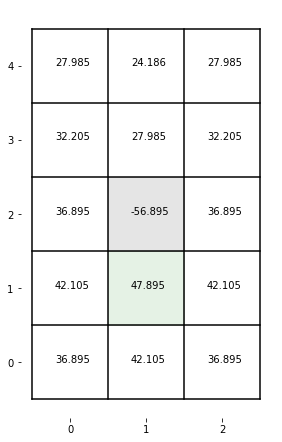

In [14]:
visualizeValueTable(gridWidth, gridHeight, goalState, [trapState], optimalValues)

In [12]:
policy

{(0, 0): {(1, 0): 0.5, (0, 1): 0.5},
 (0, 1): {(1, 0): 1.0},
 (0, 2): {(0, -1): 1.0},
 (0, 3): {(0, -1): 1.0},
 (0, 4): {(0, -1): 1.0},
 (1, 0): {(0, 1): 1.0},
 (1, 1): {(1, 0): 0.3333333333333333,
  (-1, 0): 0.3333333333333333,
  (0, -1): 0.3333333333333333},
 (1, 2): {(0, -1): 1.0},
 (1, 3): {(1, 0): 0.5, (-1, 0): 0.5},
 (1, 4): {(1, 0): 0.3333333333333333,
  (-1, 0): 0.3333333333333333,
  (0, -1): 0.3333333333333333},
 (2, 0): {(0, 1): 0.5, (-1, 0): 0.5},
 (2, 1): {(-1, 0): 1.0},
 (2, 2): {(0, -1): 1.0},
 (2, 3): {(0, -1): 1.0},
 (2, 4): {(0, -1): 1.0}}

## Example 2: Stochastic

In [15]:
gridWidth = 4
gridHeight = 4
allActions = [(1,0), (0,1), (-1,0), (0,-1)]
goalState = (3,1)
trapState = (1,1)

np.random.seed(1000)
getTransition = SetupSlipperyTransition(gridWidth, gridHeight, allActions)
transition = getTransition()

getReward = SetupRewardTable(transition, allActions, goalState, trapState)
reward = getReward()

value = {state:0 for state in reward.keys()}


performValueIteration = ValueIteration(transition, reward, value, .0001, .9)
optimalValues, policy = performValueIteration()

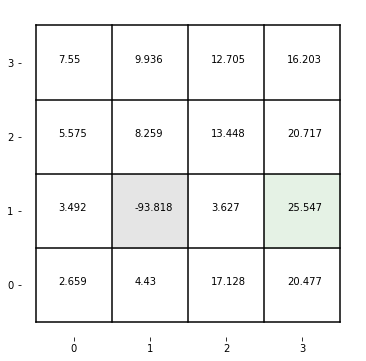

In [19]:
visualizeValueTable(gridWidth, gridHeight, goalState, [trapState], optimalValues)

In [17]:
policy

{(0, 0): {(1, 0): 1.0},
 (0, 1): {(0, 1): 1.0},
 (0, 2): {(1, 0): 1.0},
 (0, 3): {(1, 0): 1.0},
 (1, 0): {(1, 0): 1.0},
 (1, 1): {(0, 1): 1.0},
 (1, 2): {(0, 1): 1.0},
 (1, 3): {(1, 0): 1.0},
 (2, 0): {(1, 0): 1.0},
 (2, 1): {(0, 1): 1.0},
 (2, 2): {(1, 0): 1.0},
 (2, 3): {(1, 0): 1.0},
 (3, 0): {(0, 1): 1.0},
 (3, 1): {(0, 1): 1.0},
 (3, 2): {(0, -1): 1.0},
 (3, 3): {(0, -1): 1.0}}

## Examples Raw Inputs:

In [ ]:
"""
    Example 1: Deterministic Transition
"""
transitionTableDet = {(0, 0): {(1, 0): {(1, 0): 1},(0, 1): {(0, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(0, 0): 1}},(0, 1): {(1, 0): {(1, 1): 1},(0, 1): {(0, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(0, 0): 1}},(0, 2): {(1, 0): {(1, 2): 1},(0, 1): {(0, 2): 1},(-1, 0): {(0, 2): 1},(0, -1): {(0, 1): 1}},(1, 0): {(1, 0): {(2, 0): 1},(0, 1): {(1, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(1, 0): 1}},(1, 1): {(1, 0): {(2, 1): 1},(0, 1): {(1, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(1, 0): 1}},(1, 2): {(1, 0): {(2, 2): 1},(0, 1): {(1, 2): 1},(-1, 0): {(0, 2): 1},(0, -1): {(1, 1): 1}},(2, 0): {(1, 0): {(3, 0): 1},(0, 1): {(2, 1): 1},(-1, 0): {(1, 0): 1},(0, -1): {(2, 0): 1}},(2, 1): {(1, 0): {(3, 1): 1},(0, 1): {(2, 2): 1},(-1, 0): {(1, 1): 1},(0, -1): {(2, 0): 1}},(2, 2): {(1, 0): {(3, 2): 1},(0, 1): {(2, 2): 1},(-1, 0): {(1, 2): 1},(0, -1): {(2, 1): 1}},(3, 0): {(1, 0): {(3, 0): 1},(0, 1): {(3, 1): 1},(-1, 0): {(2, 0): 1},(0, -1): {(3, 0): 1}},(3, 1): {(1, 0): {(3, 1): 1},(0, 1): {(3, 2): 1},(-1, 0): {(2, 1): 1},(0, -1): {(3, 0): 1}},(3, 2): {(1, 0): {(3, 2): 1},(0, 1): {(3, 2): 1},(-1, 0): {(2, 2): 1},(0, -1): {(3, 1): 1}}}
rewardTableDet = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1}},(1, 1): {(1, 0): {(2, 1): 10},(0, 1): {(1, 2): 10},(-1, 0): {(0, 1): 10},(0, -1): {(1, 0): 10}},(1, 2): {(1, 0): {(2, 2): -100},(0, 1): {(1, 2): -1},(-1, 0): {(0, 2): -100},(0, -1): {(1, 1): -100}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1}},(3, 0): {(1, 0): {(3, 0): -1},(0, 1): {(3, 1): -1},(-1, 0): {(2, 0): -1},(0, -1): {(3, 0): -1}},(3, 1): {(1, 0): {(3, 1): -1},(0, 1): {(3, 2): -1},(-1, 0): {(2, 1): -1},(0, -1): {(3, 0): -1}},(3, 2): {(1, 0): {(3, 2): -1},(0, 1): {(3, 2): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1}}}
valueTableDet = {(0, 0): 0,(0, 1): 0,(0, 2): 0,(1, 0): 0,(1, 1): 0,(1, 2): 0,(2, 0): 0,(2, 1): 0,(2, 2): 0,(3, 0): 0,(3, 1): 0,(3, 2): 0}
convergenceTolerance = .0001
gamma = .9


"""
    Example 2: Probabilistic Transition
"""
transitionTable = {(0, 0): {(1, 0): {(1, 0): 0.7, (0, 1): 0.2, (0, 0): 0.1},(0, 1): {(0, 1): 0.7999999999999999, (1, 0): 0.2},(-1, 0): {(0, 0): 0.7, (1, 0): 0.2, (0, 1): 0.1},(0, -1): {(0, 0): 0.7, (1, 0): 0.1, (0, 1): 0.2}},(0, 1): {(1, 0): {(1, 1): 0.7999999999999999, (0, 1): 0.1, (0, 2): 0.1},(0, 1): {(0, 2): 0.7999999999999999, (0, 0): 0.2},(-1, 0): {(0, 1): 0.8999999999999999, (0, 0): 0.1},(0, -1): {(0, 0): 0.7999999999999999, (0, 2): 0.1, (0, 1): 0.1}},(0, 2): {(1, 0): {(1, 2): 0.7999999999999999, (0, 1): 0.2},(0, 1): {(0, 3): 0.7999999999999999, (0, 1): 0.1, (1, 2): 0.1},(-1, 0): {(0, 2): 0.7, (0, 1): 0.1, (1, 2): 0.1, (0, 3): 0.1},(0, -1): {(0, 1): 0.8999999999999999, (0, 3): 0.1}},(0, 3): {(1, 0): {(1, 3): 0.8999999999999999, (0, 2): 0.1},(0, 1): {(0, 3): 0.9999999999999999},(-1, 0): {(0, 3): 0.7999999999999999, (0, 2): 0.1, (1, 3): 0.1},(0, -1): {(0, 2): 0.7999999999999999, (0, 3): 0.2}},(1, 0): {(1, 0): {(2, 0): 0.8999999999999999, (1, 1): 0.1},(0, 1): {(1, 1): 0.8999999999999999, (1, 0): 0.1},(-1, 0): {(0, 0): 0.7, (1, 1): 0.2, (2, 0): 0.1},(0, -1): {(1, 0): 0.7999999999999999, (0, 0): 0.2}},(1, 1): {(1, 0): {(2, 1): 0.7999999999999999, (1, 0): 0.1, (0, 1): 0.1},(0, 1): {(1, 2): 0.7, (2, 1): 0.30000000000000004},(-1, 0): {(0, 1): 0.7, (2, 1): 0.1, (1, 0): 0.2},(0, -1): {(1, 0): 0.7999999999999999, (0, 1): 0.1, (2, 1): 0.1}},(1, 2): {(1, 0): {(2, 2): 0.7999999999999999, (1, 3): 0.1, (1, 1): 0.1},(0, 1): {(1, 3): 0.8999999999999999, (2, 2): 0.1},(-1, 0): {(0, 2): 0.8999999999999999, (1, 1): 0.1},(0, -1): {(1, 1): 0.7999999999999999, (2, 2): 0.1, (0, 2): 0.1}},(1, 3): {(1, 0): {(2, 3): 0.7999999999999999, (1, 3): 0.2},(0, 1): {(1, 3): 0.7999999999999999, (2, 3): 0.1, (0, 3): 0.1},(-1, 0): {(0, 3): 0.7, (2, 3): 0.1, (1, 2): 0.2},(0, -1): {(1, 2): 0.7999999999999999, (0, 3): 0.2}},(2, 0): {(1, 0): {(3, 0): 0.8999999999999999, (2, 0): 0.1},(0, 1): {(2, 1): 0.7999999999999999, (3, 0): 0.1, (1, 0): 0.1},(-1, 0): {(1, 0): 0.7, (2, 0): 0.2, (2, 1): 0.1},(0, -1): {(2, 0): 0.7, (2, 1): 0.2, (1, 0): 0.1}},(2, 1): {(1, 0): {(3, 1): 0.7999999999999999, (1, 1): 0.2},(0, 1): {(2, 2): 0.7, (1, 1): 0.1, (3, 1): 0.2},(-1, 0): {(1, 1): 0.7, (2, 0): 0.1, (2, 2): 0.1, (3, 1): 0.1},(0, -1): {(2, 0): 0.7, (1, 1): 0.2, (3, 1): 0.1}},(2, 2): {(1, 0): {(3, 2): 0.7, (1, 2): 0.1, (2, 1): 0.2},(0, 1): {(2, 3): 0.7999999999999999, (2, 1): 0.2},(-1, 0): {(1, 2): 0.7999999999999999, (2, 1): 0.1, (3, 2): 0.1},(0, -1): {(2, 1): 0.7999999999999999, (1, 2): 0.1, (3, 2): 0.1}},(2, 3): {(1, 0): {(3, 3): 0.7, (2, 3): 0.2, (2, 2): 0.1},(0, 1): {(2, 3): 0.7999999999999999, (2, 2): 0.1, (3, 3): 0.1},(-1, 0): {(1, 3): 0.8999999999999999, (2, 3): 0.1},(0, -1): {(2, 2): 0.7, (3, 3): 0.1, (1, 3): 0.1, (2, 3): 0.1}},(3, 0): {(1, 0): {(3, 0): 0.7, (3, 1): 0.1, (2, 0): 0.2},(0, 1): {(3, 1): 0.7999999999999999, (2, 0): 0.2},(-1, 0): {(2, 0): 0.7999999999999999, (3, 0): 0.2},(0, -1): {(3, 0): 0.7999999999999999, (2, 0): 0.1, (3, 1): 0.1}},(3, 1): {(1, 0): {(3, 1): 0.8999999999999999, (3, 2): 0.1},(0, 1): {(3, 2): 0.7, (2, 1): 0.2, (3, 0): 0.1},(-1, 0): {(2, 1): 0.7999999999999999, (3, 0): 0.1, (3, 1): 0.1},(0, -1): {(3, 0): 0.7999999999999999, (2, 1): 0.2}},(3, 2): {(1, 0): {(3, 2): 0.7999999999999999, (3, 1): 0.1, (2, 2): 0.1},(0, 1): {(3, 3): 0.7, (3, 2): 0.2, (2, 2): 0.1},(-1, 0): {(2, 2): 0.9999999999999999},(0, -1): {(3, 1): 0.7999999999999999, (3, 3): 0.1, (3, 2): 0.1}},(3, 3): {(1, 0): {(3, 3): 0.7999999999999999, (3, 2): 0.2},(0, 1): {(3, 3): 0.7999999999999999, (3, 2): 0.2},(-1, 0): {(2, 3): 0.7999999999999999, (3, 2): 0.1, (3, 3): 0.1},(0, -1): {(3, 2): 0.7999999999999999, (2, 3): 0.2}}}
rewardTable = {(0, 0): {(1, 0): {(1, 0): -1, (0, 1): -1, (0, 0): -1},(0, 1): {(0, 1): -1, (1, 0): -1},(-1, 0): {(0, 0): -1, (1, 0): -1, (0, 1): -1},(0, -1): {(0, 0): -1, (1, 0): -1, (0, 1): -1}},(0, 1): {(1, 0): {(1, 1): -1, (0, 1): -1, (0, 2): -1},(0, 1): {(0, 2): -1, (0, 0): -1},(-1, 0): {(0, 1): -1, (0, 0): -1},(0, -1): {(0, 0): -1, (0, 2): -1, (0, 1): -1}},(0, 2): {(1, 0): {(1, 2): -1, (0, 1): -1},(0, 1): {(0, 3): -1, (0, 1): -1, (1, 2): -1},(-1, 0): {(0, 2): -1, (0, 1): -1, (1, 2): -1, (0, 3): -1},(0, -1): {(0, 1): -1, (0, 3): -1}},(0, 3): {(1, 0): {(1, 3): -1, (0, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 3): -1, (0, 2): -1, (1, 3): -1},(0, -1): {(0, 2): -1, (0, 3): -1}},(1, 0): {(1, 0): {(2, 0): -1, (1, 1): -1},(0, 1): {(1, 1): -1, (1, 0): -1},(-1, 0): {(0, 0): -1, (1, 1): -1, (2, 0): -1},(0, -1): {(1, 0): -1, (0, 0): -1}},(1, 1): {(1, 0): {(2, 1): -100, (1, 0): -100, (0, 1): -100},(0, 1): {(1, 2): -100, (2, 1): -100},(-1, 0): {(0, 1): -100, (2, 1): -100, (1, 0): -100},(0, -1): {(1, 0): -100, (0, 1): -100, (2, 1): -100}},(1, 2): {(1, 0): {(2, 2): -1, (1, 3): -1, (1, 1): -1},(0, 1): {(1, 3): -1, (2, 2): -1},(-1, 0): {(0, 2): -1, (1, 1): -1},(0, -1): {(1, 1): -1, (2, 2): -1, (0, 2): -1}},(1, 3): {(1, 0): {(2, 3): -1, (1, 3): -1},(0, 1): {(1, 3): -1, (2, 3): -1, (0, 3): -1},(-1, 0): {(0, 3): -1, (2, 3): -1, (1, 2): -1},(0, -1): {(1, 2): -1, (0, 3): -1}},(2, 0): {(1, 0): {(3, 0): -1, (2, 0): -1},(0, 1): {(2, 1): -1, (3, 0): -1, (1, 0): -1},(-1, 0): {(1, 0): -1, (2, 0): -1, (2, 1): -1},(0, -1): {(2, 0): -1, (2, 1): -1, (1, 0): -1}},(2, 1): {(1, 0): {(3, 1): -1, (1, 1): -1},(0, 1): {(2, 2): -1, (1, 1): -1, (3, 1): -1},(-1, 0): {(1, 1): -1, (2, 0): -1, (2, 2): -1, (3, 1): -1},(0, -1): {(2, 0): -1, (1, 1): -1, (3, 1): -1}},(2, 2): {(1, 0): {(3, 2): -1, (1, 2): -1, (2, 1): -1},(0, 1): {(2, 3): -1, (2, 1): -1},(-1, 0): {(1, 2): -1, (2, 1): -1, (3, 2): -1},(0, -1): {(2, 1): -1, (1, 2): -1, (3, 2): -1}},(2, 3): {(1, 0): {(3, 3): -1, (2, 3): -1, (2, 2): -1},(0, 1): {(2, 3): -1, (2, 2): -1, (3, 3): -1},(-1, 0): {(1, 3): -1, (2, 3): -1},(0, -1): {(2, 2): -1, (3, 3): -1, (1, 3): -1, (2, 3): -1}},(3, 0): {(1, 0): {(3, 0): -1, (3, 1): -1, (2, 0): -1},(0, 1): {(3, 1): -1, (2, 0): -1},(-1, 0): {(2, 0): -1, (3, 0): -1},(0, -1): {(3, 0): -1, (2, 0): -1, (3, 1): -1}},(3, 1): {(1, 0): {(3, 1): -1, (3, 2): 10},(0, 1): {(3, 2): 10, (2, 1): 10, (3, 0): 10},(-1, 0): {(2, 1): 10, (3, 0): 10, (3, 1): -1},(0, -1): {(3, 0): 10, (2, 1): 10}},(3, 2): {(1, 0): {(3, 2): -1, (3, 1): -1, (2, 2): -1},(0, 1): {(3, 3): -1, (3, 2): -1, (2, 2): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1, (3, 3): -1, (3, 2): -1}},(3, 3): {(1, 0): {(3, 3): -1, (3, 2): -1},(0, 1): {(3, 3): -1, (3, 2): -1},(-1, 0): {(2, 3): -1, (3, 2): -1, (3, 3): -1},(0, -1): {(3, 2): -1, (2, 3): -1}}}
valueTable = {(0, 0): 0,(0, 1): 0,(0, 2): 0,(0, 3): 0,(1, 0): 0,(1, 1): 0,(1, 2): 0,(1, 3): 0,(2, 0): 0,(2, 1): 0,(2, 2): 0,(2, 3): 0,(3, 0): 0,(3, 1): 0,(3, 2): 0,(3, 3): 0}
convergenceTolerance = .0001
gamma = .9